## (i)

In [77]:
import torchvision as thv
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt

# data in torchvison mnist dataset are normalized, so we need to use threshold 0.5
transform = thv.transforms.Compose([
    thv.transforms.Resize((14, 14)),
    thv.transforms.ToTensor(),
    lambda x: (x > 0.5).float()
])

train_dataset = thv.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
indices = [np.where(train_dataset.targets.numpy() == i)[0][:1000] for i in range(10)]
choosed = np.concatenate(indices)
train_dataset.data = train_dataset.data[choosed]
train_dataset.targets = train_dataset.targets[choosed]
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

## (ii)

In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(196, 128)
        self.mean = nn.Linear(128, 8)
        self.log_var = nn.Linear(128, 8)

    def forward(self, x):
        x = x.view(-1, 14 * 14)
        x = torch.tanh(self.linear1(x))
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(8, 128)
        self.linear2 = nn.Linear(128, 196)

    def forward(self, z):
        x = torch.tanh(self.linear1(z))
        x = torch.sigmoid(self.linear2(x))
        return x.view(-1, 1, 14, 14)


encoder = Encoder().to(device)
decoder = Decoder().to(device)
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4)

def calculate_loss(x, x_reconst, mu, log_var):
    reconstruction_loss = nn.BCELoss(reduction='sum')(x_reconst, x)
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss / log_var.shape[0], kl_divergence / log_var.shape[0]


num_epochs = 50
result_loss = []
reconstruction = []
kl = []
encoder.train()
decoder.train()
for epoch in range(num_epochs):
    losses = []
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)

        optimizer.zero_grad()

        mu, log_var = encoder(images)
        sigma = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(sigma)
        z = mu + epsilon * sigma
        decoded = decoder(z)

        reconstruction_loss, kl_divergence = calculate_loss(images, decoded, mu, log_var)
        loss = reconstruction_loss + kl_divergence
        reconstruction.append(reconstruction_loss.item())
        kl.append(kl_divergence.item())
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(losses):.4f}')
    result_loss.append(np.mean(losses))

Epoch [1/50], Loss: 116.9643
Epoch [2/50], Loss: 75.2627
Epoch [3/50], Loss: 63.2424
Epoch [4/50], Loss: 58.6469
Epoch [5/50], Loss: 56.1024
Epoch [6/50], Loss: 54.4040
Epoch [7/50], Loss: 53.0902
Epoch [8/50], Loss: 51.9848
Epoch [9/50], Loss: 51.2476
Epoch [10/50], Loss: 50.4601
Epoch [11/50], Loss: 49.9479
Epoch [12/50], Loss: 49.5056
Epoch [13/50], Loss: 49.1121
Epoch [14/50], Loss: 48.4276
Epoch [15/50], Loss: 47.8799
Epoch [16/50], Loss: 47.3366
Epoch [17/50], Loss: 46.7608
Epoch [18/50], Loss: 46.1849
Epoch [19/50], Loss: 45.4961
Epoch [20/50], Loss: 45.0622
Epoch [21/50], Loss: 44.5507
Epoch [22/50], Loss: 44.0811
Epoch [23/50], Loss: 43.7420
Epoch [24/50], Loss: 43.4028
Epoch [25/50], Loss: 43.0608
Epoch [26/50], Loss: 42.8091
Epoch [27/50], Loss: 42.4771
Epoch [28/50], Loss: 42.2195
Epoch [29/50], Loss: 42.0273
Epoch [30/50], Loss: 41.7019
Epoch [31/50], Loss: 41.4625
Epoch [32/50], Loss: 41.3099
Epoch [33/50], Loss: 41.0869
Epoch [34/50], Loss: 40.8619
Epoch [35/50], Loss: 4

## (iii)

Text(0, 0.5, 'Reconstruction Error')

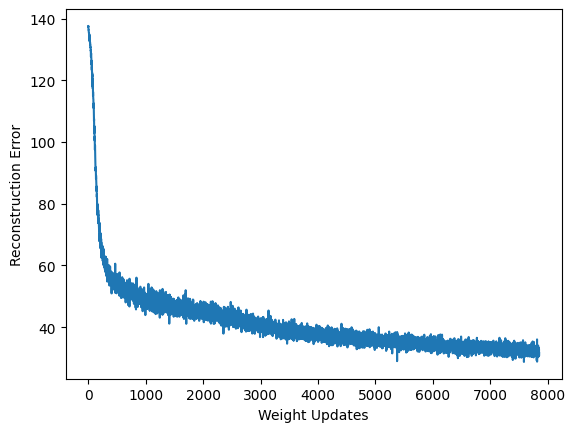

In [104]:
plt.plot(reconstruction)
plt.xlabel("Weight Updates")
plt.ylabel("Reconstruction Error")

Text(0, 0.5, 'KL Divergence')

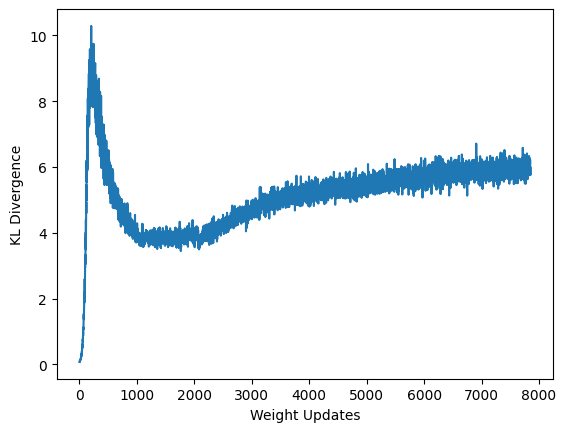

In [105]:
plt.plot(kl)
plt.xlabel("Weight Updates")
plt.ylabel("KL Divergence")

## (iv)

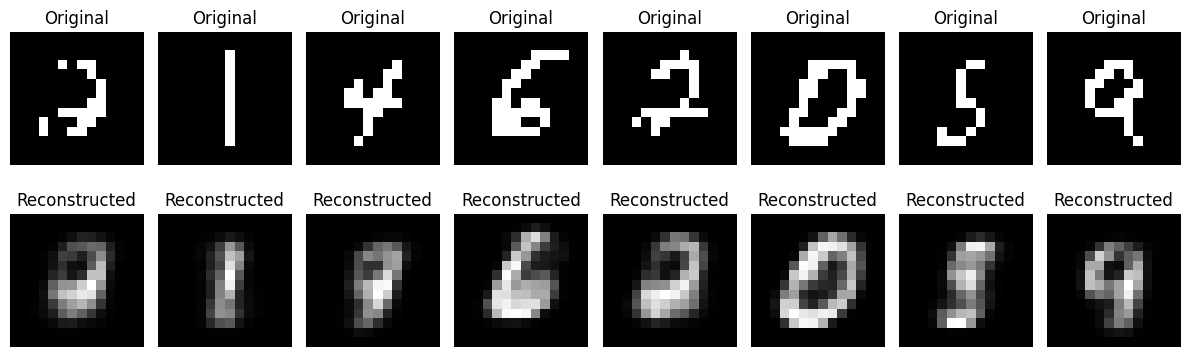

In [107]:
encoder.eval()
decoder.eval()
num_images = 8
selected = []
for i, (images, _) in enumerate(train_loader):
    selected.append(images)
    if i + 1 >= (num_images // train_loader.batch_size):
        break

selected = torch.cat(selected, dim=0)[:num_images].to(device)


with torch.no_grad():
    mean, _ = encoder(selected)
    reconstructed = decoder(mean)

plt.figure(figsize=(12, 4))
for i in range(num_images):
    plt.subplot(2, num_images, i + 1)
    plt.imshow(selected[i].cpu().squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()

## (v)

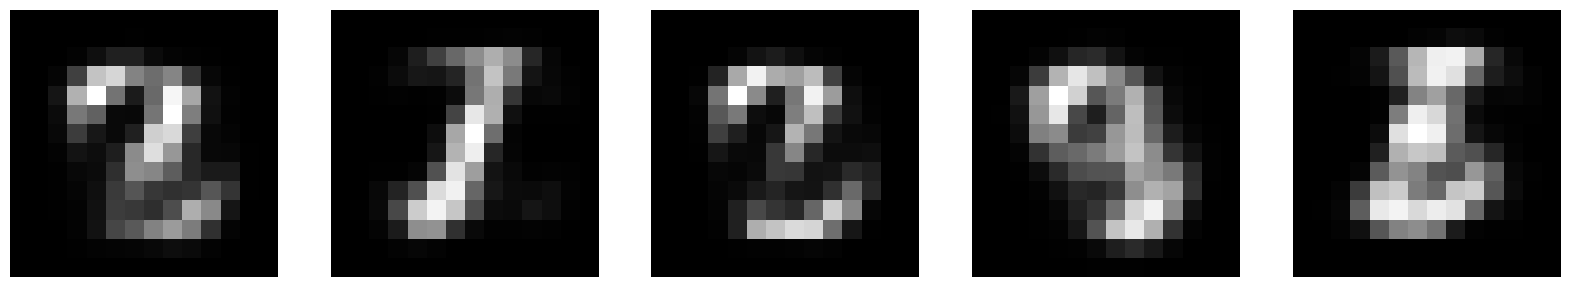

In [111]:
with torch.no_grad():
    sampled = torch.randn(5, 8).to(device)
    generated = decoder(sampled)

generated = generated.cpu().detach().numpy()

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    axes[i].imshow(generated[i].squeeze(), cmap='gray')
    axes[i].axis('off')
plt.show()